## Testing how runtime scales with number of phases in the composite

In [1]:
# Import necessary packages
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
import time

# Custom imports
sys.path.insert(1, '../core')
from optimization import HashinShtrikman
from user_input import MaterialProperty, Material, MixtureProperty, Mixture, UserInput

/Users/carlabecker/opt/anaconda3/envs/carla_mp_api/lib/python3.9/site-packages/mpcontribs/client/__init__.py:88: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)


In [2]:
# Testing without calls to generate final dict (faster)
import json
consolidated_dict = {}
with open("consolidated_dict_02_11_2024_23_45_58") as f:
    consolidated_dict = json.load(f)

In [3]:
# Define the number of trials
num_trials = 10

## 2 phase composite

In [4]:
# Example material matches for an n=2 phase compositie
mat_1_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
mat_2_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 'mat2': mat_2_ids}

In [5]:
# Need user input to create an HS instance
# Use same bounds for all materials
properties_mat_1 = [
    MaterialProperty(prop='elec_cond_300k_low_doping', upper_bound=20, lower_bound=1),
    MaterialProperty(prop='therm_cond_300k_low_doping', upper_bound=0.001, lower_bound=1e-5),
    MaterialProperty(prop='bulk_modulus', upper_bound=400, lower_bound=50),
    MaterialProperty(prop='shear_modulus', upper_bound=400, lower_bound=80),
    MaterialProperty(prop='universal_anisotropy', upper_bound=3, lower_bound=0.5),
]

# Define properties for the mixture
properties_mixture = [
    MixtureProperty(prop='elec_cond_300k_low_doping', desired_prop=9),
    MixtureProperty(prop='therm_cond_300k_low_doping', desired_prop=0.007),
    MixtureProperty(prop='bulk_modulus', desired_prop=234),
    MixtureProperty(prop='shear_modulus', desired_prop=150),
    MixtureProperty(prop='universal_anisotropy', desired_prop=1.5),
]

# Create Material & Mixture instances
mat_1 = Material(name='mat_1', properties=properties_mat_1)
mat_2 = Material(name='mat_2', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mixture': {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}}


In [6]:
# Create an HS instance for testing
HS2 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-07 22:21:35,970 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-07 22:21:35,978 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-07 22:21:35,979 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mixture': {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}

In [7]:
# Perform Optimizaztion several times to observe variation
HS2_times = []
for i in range(num_trials):
    start = time.time()
    HS2.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS2_time = end - start
    print(f'Trial {i}: {HS2_time} seconds')
    HS2_times.append(HS2_time)

Trial 0: 3.897205114364624 seconds
Trial 1: 3.9879698753356934 seconds
Trial 2: 4.778400897979736 seconds
Trial 3: 4.151442050933838 seconds
Trial 4: 4.159657955169678 seconds
Trial 5: 3.554763078689575 seconds
Trial 6: 3.854065179824829 seconds
Trial 7: 3.680905342102051 seconds
Trial 8: 3.6099331378936768 seconds
Trial 9: 4.486659049987793 seconds


## 3 phase composite

In [8]:
# Example material matches for an n=3 phase compositie
mat_3_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 'mat2': mat_2_ids, 'mat3': mat_3_ids}

In [9]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_3 = Material(name='mat_3', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [10]:
# Create an HS instance for testing
HS3 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-07 22:22:16,223 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-07 22:22:16,243 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-07 22:22:16,245 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [11]:
# Perform Optimizaztion several times to observe variation
HS3_times = []
for i in range(num_trials):
    start = time.time()
    HS3.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS3_time = end - start
    print(f'Trial {i}: {HS3_time} seconds')
    HS3_times.append(HS3_time)

Trial 0: 5.112205266952515 seconds
Trial 1: 5.305461168289185 seconds
Trial 2: 4.3776750564575195 seconds
Trial 3: 3.9895009994506836 seconds
Trial 4: 4.1028430461883545 seconds
Trial 5: 4.114718914031982 seconds
Trial 6: 4.307523012161255 seconds
Trial 7: 3.960404872894287 seconds
Trial 8: 4.064286947250366 seconds
Trial 9: 3.93088698387146 seconds


## 4 phase composite

In [12]:
# Example material matches for an n=3 phase compositie
mat_4_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 'mat2': mat_2_ids, 'mat3': mat_3_ids, 'mat4': mat_4_ids}

In [13]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_4 = Material(name='mat_4', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [14]:
# Create an HS instance for testing
HS4 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-07 22:22:59,558 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-07 22:22:59,565 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-07 22:22:59,566 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [15]:
# Perform Optimizaztion several times to observe variation
HS4_times = []
for i in range(num_trials):
    start = time.time()
    HS4.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS4_time = end - start
    print(f'Trial {i}: {HS4_time} seconds')
    HS4_times.append(HS4_time)

---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
Cell In[15], line 5
      3 for i in range(num_trials):
      4     start = time.time()
----> 5     HS4.set_HS_optim_params(gen_counter=False)
      6     end = time.time()
      7     HS4_time = end - start

File ~/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/examples/../core/optimization.py:615, in HashinShtrikman.set_HS_optim_params(self, gen_counter)
    607 # Randomly populate first generation  
    608 population = Population(num_materials=self.num_materials, 
    609                         num_properties=self.num_properties, 
    610                         property_categories=self.property_categories, 
   (...)
    613                         ga_params=self.ga_params,
    614                         calc_guide=self.calc_guide)
--> 615 population.set_

## 5 phase composite

In [68]:
# Example material matches for an n=3 phase compositie
mat_5_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 'mat2': mat_2_ids, 'mat3': mat_3_ids, 'mat4': mat_4_ids, 'mat5': mat_5_ids}

In [69]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_5 = Material(name='mat_5', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [70]:
# Create an HS instance for testing
HS5 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-09-25 14:19:36,195 - custom_logger - INFO - Loading property categories from /Users/HPSahasrabuddhe/code/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-09-25 14:19:36,199 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-09-25 14:19:36,199 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [71]:
# Perform Optimizaztion several times to observe variation
HS5_times = []
for i in range(num_trials):
    start = time.time()
    HS5.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS5_time = end - start
    print(f'Trial {i}: {HS5_time} seconds')
    HS5_times.append(HS5_time)

Trial 0: 1.4025251865386963 seconds
Trial 1: 1.3674330711364746 seconds
Trial 2: 1.4013960361480713 seconds
Trial 3: 1.4197118282318115 seconds
Trial 4: 1.3490056991577148 seconds
Trial 5: 1.372788906097412 seconds
Trial 6: 1.342529058456421 seconds
Trial 7: 1.3934321403503418 seconds
Trial 8: 1.389230728149414 seconds
Trial 9: 1.366283893585205 seconds


## 6 phase composite

In [72]:
# Example material matches for an n=3 phase compositie
mat_6_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 
                'mat2': mat_2_ids, 
                'mat3': mat_3_ids, 
                'mat4': mat_4_ids, 
                'mat5': mat_5_ids, 
                'mat6': mat_6_ids}

In [73]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_6 = Material(name='mat_6', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5, mat_6], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [74]:
# Create an HS instance for testing
HS6 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-09-25 14:19:50,428 - custom_logger - INFO - Loading property categories from /Users/HPSahasrabuddhe/code/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-09-25 14:19:50,432 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-09-25 14:19:50,433 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [75]:
# Perform Optimizaztion several times to observe variation
HS6_times = []
for i in range(num_trials):
    start = time.time()
    HS6.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS6_time = end - start
    print(f'Trial {i}: {HS6_time} seconds')
    HS6_times.append(HS6_time)

Trial 0: 1.401339054107666 seconds
Trial 1: 1.4096519947052002 seconds
Trial 2: 1.398932933807373 seconds
Trial 3: 1.3935730457305908 seconds
Trial 4: 1.399022102355957 seconds
Trial 5: 1.5442848205566406 seconds
Trial 6: 1.4082329273223877 seconds
Trial 7: 1.4118678569793701 seconds
Trial 8: 1.4082269668579102 seconds
Trial 9: 1.3658859729766846 seconds


## 7 phase composite

In [76]:
# Example material matches for an n=3 phase compositie
mat_7_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 
                'mat2': mat_2_ids, 
                'mat3': mat_3_ids, 
                'mat4': mat_4_ids, 
                'mat5': mat_5_ids, 
                'mat6': mat_6_ids,
                'mat7': mat_7_ids}

In [77]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_7 = Material(name='mat_7', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [78]:
# Create an HS instance for testing
HS7 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-09-25 14:20:07,926 - custom_logger - INFO - Loading property categories from /Users/HPSahasrabuddhe/code/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-09-25 14:20:07,929 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-09-25 14:20:07,930 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [79]:
# Perform Optimizaztion several times to observe variation
HS7_times = []
for i in range(num_trials):
    start = time.time()
    HS7.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS7_time = end - start
    print(f'Trial {i}: {HS7_time} seconds')
    HS7_times.append(HS7_time)

Trial 0: 1.4800388813018799 seconds
Trial 1: 1.4448659420013428 seconds
Trial 2: 1.5209758281707764 seconds
Trial 3: 1.445580005645752 seconds
Trial 4: 1.4693090915679932 seconds
Trial 5: 1.4260210990905762 seconds
Trial 6: 1.4172909259796143 seconds
Trial 7: 1.3982107639312744 seconds
Trial 8: 1.4657108783721924 seconds
Trial 9: 1.4430277347564697 seconds


## 8 phase composite

In [80]:
# Example material matches for an n=3 phase compositie
mat_8_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 
                'mat2': mat_2_ids, 
                'mat3': mat_3_ids, 
                'mat4': mat_4_ids, 
                'mat5': mat_5_ids, 
                'mat6': mat_6_ids,
                'mat7': mat_7_ids,
                'mat7': mat_7_ids}

In [81]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_8 = Material(name='mat_8', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [82]:
# Create an HS instance for testing
HS8 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-09-25 14:20:22,515 - custom_logger - INFO - Loading property categories from /Users/HPSahasrabuddhe/code/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-09-25 14:20:22,519 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-09-25 14:20:22,519 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [83]:
# Perform Optimizaztion several times to observe variation
HS8_times = []
for i in range(num_trials):
    start = time.time()
    HS8.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS8_time = end - start
    print(f'Trial {i}: {HS8_time} seconds')
    HS8_times.append(HS8_time)

Trial 0: 1.4952878952026367 seconds
Trial 1: 1.4244980812072754 seconds
Trial 2: 1.4070940017700195 seconds
Trial 3: 1.426053762435913 seconds
Trial 4: 1.4612679481506348 seconds
Trial 5: 1.437178134918213 seconds
Trial 6: 1.4750609397888184 seconds
Trial 7: 1.4669222831726074 seconds
Trial 8: 1.4588091373443604 seconds
Trial 9: 1.430325984954834 seconds


## 9 phase composite

In [84]:
# Example material matches for an n=3 phase compositie
mat_9_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 
                'mat2': mat_2_ids, 
                'mat3': mat_3_ids, 
                'mat4': mat_4_ids, 
                'mat5': mat_5_ids, 
                'mat6': mat_6_ids,
                'mat7': mat_7_ids,
                'mat7': mat_7_ids,
                'mat8': mat_8_ids,
                'mat9': mat_9_ids}

In [85]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_9 = Material(name='mat_9', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8, mat_9, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8, mat_9], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [86]:
# Create an HS instance for testing
HS9 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-09-25 14:20:37,056 - custom_logger - INFO - Loading property categories from /Users/HPSahasrabuddhe/code/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-09-25 14:20:37,060 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-09-25 14:20:37,061 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [87]:
# Perform Optimizaztion several times to observe variation
HS9_times = []
for i in range(num_trials):
    start = time.time()
    HS9.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS9_time = end - start
    print(f'Trial {i}: {HS9_time} seconds')
    HS9_times.append(HS9_time)

Trial 0: 1.496387243270874 seconds
Trial 1: 1.497575044631958 seconds
Trial 2: 1.538464069366455 seconds
Trial 3: 1.493807077407837 seconds
Trial 4: 1.4842560291290283 seconds
Trial 5: 1.4732508659362793 seconds
Trial 6: 1.4676222801208496 seconds
Trial 7: 1.4612810611724854 seconds
Trial 8: 1.4392011165618896 seconds
Trial 9: 1.4744319915771484 seconds


## 10 phase composite

In [88]:
# Example material matches for an n=3 phase compositie
mat_10_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 
                'mat2': mat_2_ids, 
                'mat3': mat_3_ids, 
                'mat4': mat_4_ids, 
                'mat5': mat_5_ids, 
                'mat6': mat_6_ids,
                'mat7': mat_7_ids,
                'mat7': mat_7_ids,
                'mat8': mat_8_ids,
                'mat9': mat_9_ids,
                'mat10': mat_10_ids}

In [89]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_10 = Material(name='mat_10', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8, mat_9, mat_10, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8, mat_9, mat_10], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [90]:
# Create an HS instance for testing
HS10 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-09-25 14:20:51,957 - custom_logger - INFO - Loading property categories from /Users/HPSahasrabuddhe/code/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-09-25 14:20:51,961 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-09-25 14:20:51,961 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [91]:
# Perform Optimizaztion several times to observe variation
HS10_times = []
for i in range(num_trials):
    start = time.time()
    HS10.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS10_time = end - start
    print(f'Trial {i}: {HS10_time} seconds')
    HS10_times.append(HS10_time)

Trial 0: 1.5415308475494385 seconds
Trial 1: 1.4939138889312744 seconds
Trial 2: 1.4999470710754395 seconds
Trial 3: 1.4999947547912598 seconds
Trial 4: 1.5092039108276367 seconds
Trial 5: 1.5043699741363525 seconds
Trial 6: 1.5255520343780518 seconds
Trial 7: 1.471721887588501 seconds
Trial 8: 1.4564080238342285 seconds
Trial 9: 1.497910737991333 seconds


## Compare runtimes

In [92]:
runtimes = np.array([HS2_times, 
            HS3_times, 
            HS4_times, 
            HS5_times, 
            HS6_times, 
            HS7_times, 
            HS8_times, 
            HS9_times, 
            HS10_times])
phases = np.arange(len(runtimes)) + 2

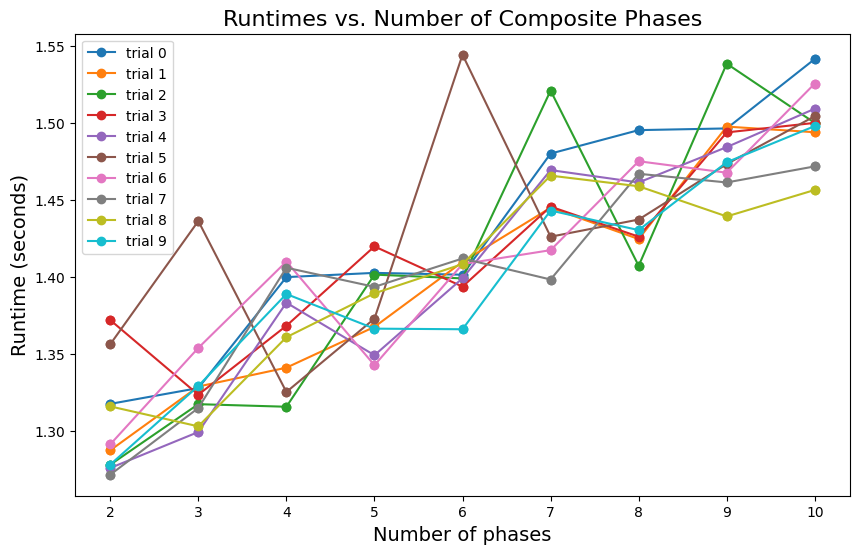

In [93]:
# Plot
plt.figure(figsize=(10, 6))

for i in range(num_trials):

    plt.plot(phases, runtimes[:, i], marker='o', linestyle='-', label=f'trial {i}')
    plt.scatter(phases, runtimes[:, i])

plt.xlabel('Number of phases', fontsize=14)
plt.ylabel('Runtime (seconds)', fontsize=14)
plt.title('Runtimes vs. Number of Composite Phases', fontsize=16)
plt.legend()

plt.show()

In [95]:
# Statistics
min_runtime = np.min(runtimes)
max_runtime = np.max(runtimes)
avg_runtime = np.mean(runtimes)
med_runtime = np.median(runtimes)

print(f'Min runtime: {min_runtime}')
print(f'Max runtime: {max_runtime}')
print(f'Average runtime: {avg_runtime}')
print(f'Median runtime: {med_runtime}')

Min runtime: 1.2713580131530762
Max runtime: 1.5442848205566406
Average runtime: 1.4093162483639188
Median runtime: 1.408229947090149
